# How to run this notebook

1. Open 2 terminal tabs
2. From Terminal A, ssh into TACC the normal way - `ssh <username>@maverick2.tacc.utexas.edu`
3. From terminal B, ssh into TACC using the command - `ssh -L localhost:8888:127.0.0.1:8888 -L localhost:6006:localhost:6006 sbansal6@maverick2.tacc.utexas.edu`
4. From terminal A, request some resources on the GPU compute resource - `idev -p gtx -L work -m 180`
5. From terminal B, log into the compute resource provisioned using - `ssh -L localhost:8888:127.0.0.1:8888 -L localhost:6006:localhost:6006 <resource-name>`
6. From terminal B, run jupyter notebook - `jupyter lab --port 8888`
7. You should be able to open the jupyter notebook on the browser of your local computer.

# TACC Assumptions

Following are the requirements:

Packages:

```
tensorflow                         2.1.0
tensorflow-estimator               2.1.0
tensorflow-gpu                     2.1.0
tensorflow-probability             0.9.0
tensorboard                        2.3.0
```

Modules:

`module load intel/17.0.4 python3/3.6.3 cuda/10.0 cudnn/7.6.2 nccl/2.4.7 tacc-singularity/3.4.2`

In addition to the above module you might need to add the following to your path:

`export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/opt/apps/cuda/10.1/targets/x86_64-linux/lib`


Because of some missing library issues in TACC and depending on the missing library you might need to find and add the library somewhere accessible and add that path to the `LD_LIBRARY_PATH`:

```
login1.maverick2(1006)$ find -O3 -L /opt/apps/ -name "*libcupti.so.10.1*"
/opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1
/opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1.208

login1.maverick2(1006)$ cp /opt/apps/cuda/10.1/extras/CUPTI/lib64/libcupti.so.10.1 $WORK/libcupti.so.10.1
login1.maverick2(1006)$ export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$WORK

```

# Experiment Details

There are 2 datasets - 

**A**: orig_faced + defaced volumes

**B**: refaced + defaced volumes


1. Randomly select 49 volumes from faced and refaced datasets. 
2. Generate a new dataset T_A, with these 49 faced + the corresponding 49 defaced, and T_B with the 49 defaced + 49 re-faced.
3. Put T_A and T_B aside
4. Run your 15-fold CV on the remainder:

**A_2 (N = 1000x2)**: 1000 faced + 1000 defaced

**B_2 (N = 1000x2)**: 1000 defaced + 1000 re-faced



## Step1 and Step2

In [10]:
import os, sys
sys.path.append("..")
import numpy as np
from glob import glob
import pandas as pd
import random
from random import shuffle

# Define paths
ROOT_DIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/conformed'

face_path = os.path.join(ROOT_DIR, 'face/128')
defaced_path = os.path.join(ROOT_DIR, 'face_defaced/128')
refaced_path = os.path.join(ROOT_DIR, 'face_refaced/128')

paths_d = []
paths_f = []
paths_r = []

for path in glob(defaced_path + "/*/*.nii*"):
    DS = path.split('/')[-2]
    paths_d.append(path)
    
for path in glob(refaced_path + "/*/*.nii*"):
    DS = path.split('/')[-2]
    paths_r.append(path)
    
for path in glob(face_path + "/*/*.nii*"):
    DS = path.split('/')[-2]
    paths_f.append(path)
    

def generate_datasets(fpaths, dpaths, size, typ ='faced'):
    
    if typ not in ['faced', 'refaced']:
        print("Incorrect value for t. Choose from [faced, refaced]")
        return
    
    random.shuffle(fpaths)
    test_f = fpaths[:size]
    main_f = fpaths[size:]

    test_d = []
    for t in test_f:
        if typ == 'faced':
            test_d.append(t.replace('face', 'face_defaced'))
        
        if typ == 'refaced':
            DS = t.split('/')[-2]
            sub = t.split('/')[-1].replace('_defaced_refaced', '').split('.nii.gz')[0]
            search_pattern = os.path.join(DS, sub)
            
            # match pattern from defaced dataset
            for _d in dpaths:
                if search_pattern in _d:
                    test_d.append(_d)
                

    test = test_f + test_d
    labels_test = [1]*len(test_f) + [0]*len(test_d)
    
    # remove T_A_D from defaced volume set
    main_d = list(set(dpaths) - set(test_d))
    
    labels_main = [1]*len(main_f) + [0]*len(main_d)
    main = main_f + main_d
    
    return main, labels_main, test, labels_test

A_2, L_A_2, T_A, L_T_A = generate_datasets(paths_f, paths_d, 49, typ='faced')
B_2, L_B_2, T_B, L_T_B = generate_datasets(paths_r, paths_d, 49, typ='refaced')

print(len(A_2), len(T_A))
print(len(B_2), len(T_B))


1998 98
1983 100


## Generate n-fold CV Datasets

In [12]:
from operator import itemgetter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from random import shuffle
import os

def generate_CSV(paths, labels, save_path, test_paths=None, test_labels=None, n=15, mode='CV'):
    
    os.makedirs(save_path, exist_ok=True)
    
    df = pd.DataFrame()
    df["X"] = paths
    df["Y"] = labels
    df.to_csv(os.path.join(save_path, "all.csv"))
    
    if mode == 'CV':
        SPLITS = n
        skf = StratifiedKFold(n_splits=SPLITS)
        fold_no = 1

        for train_index, test_index in skf.split(paths, labels):
            out_path = os.path.join(save_path, "train_test_fold_{}/csv/".format(fold_no))

            if not os.path.exists(out_path):
                os.makedirs(out_path)

            image_train, image_test = (
                itemgetter(*train_index)(paths),
                itemgetter(*test_index)(paths),
            )

            label_train, label_test = (
                itemgetter(*train_index)(labels),
                itemgetter(*test_index)(labels),
            )

            train_data = {"X": image_train , "Y": label_train}
            df_train = pd.DataFrame(train_data)
            df_train.to_csv(os.path.join(out_path, "training.csv"), index=False)

            validation_data = {"X": image_test, "Y": label_test}
            df_validation = pd.DataFrame(validation_data)
            df_validation.to_csv(os.path.join(out_path, "validation.csv"), index=False)

            fold_no += 1
    else:
        train_data = {"X": paths , "Y": labels}
        df_train = pd.DataFrame(train_data)
        df_train.to_csv(os.path.join(save_path, "training.csv"), index=False)
        
        test_data = {"X": test_paths , "Y": test_labels}
        df_test = pd.DataFrame(test_data)
        df_test.to_csv(os.path.join(save_path, "testing.csv"), index=False)
        
ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments'

## CROSS VALIDATION
# generate_CSV(A_2, L_A_2, "experiments/experiment_A/csv_F15")
generate_CSV(B_2, L_B_2, os.path.join(ROOTDIR, "experiment_B/128/csv_F15"), mode='CV')


## DEFINE A ROOT DIR where all the data will be stored <<<<<
# ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments' 

## FULL DATASET
# generate_CSV(A_2,
#              L_A_2,
#              os.path.join(ROOTDIR, 'experiment_A/128/csv_full'),
#              test_paths=T_A,
#              test_labels=L_T_A,
#              mode='full')

# generate_CSV(B_2,
#              L_B_2,
#              os.path.join(ROOTDIR, 'experiment_B/128/csv_full'),
#              test_paths=T_B,
#              test_labels=L_T_B,
#              mode='full')


# Generate tfrecords for n-fold CV datasets

In [14]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd


def generate_tfrecords(csv_path, records_save_path, mode='CV'):
    
    os.makedirs(records_save_path, exist_ok=True)

    train_csv_path = os.path.join(csv_path, "training.csv")
    

    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    train_D = list(zip(train_paths, train_labels))
    
    random.shuffle(train_D)

    train_write_path = os.path.join(records_save_path, 'data-train_shard-{shard:03d}.tfrec')
    
    nobrainer.tfrecord.write(
        features_labels=train_D,
        filename_template=train_write_path,
        examples_per_shard=3)
    
    if mode =='CV':
        valid_csv_path = os.path.join(csv_path, "validation.csv")
        valid_paths = pd.read_csv(valid_csv_path)["X"].values
        valid_labels = pd.read_csv(valid_csv_path)["Y"].values
        valid_D = list(zip(valid_paths, valid_labels))
        random.shuffle(valid_D)
        valid_write_path = os.path.join(records_save_path, 'data-valid_shard-{shard:03d}.tfrec')

        nobrainer.tfrecord.write(
            features_labels=valid_D,
            filename_template=valid_write_path,
            examples_per_shard=1)
    
    if mode == 'test':
        test_csv_path = os.path.join(csv_path, "testing.csv")
        test_paths = pd.read_csv(test_csv_path)["X"].values
        test_labels = pd.read_csv(test_csv_path)["Y"].values
        test_D = list(zip(test_paths, test_labels))
        random.shuffle(test_D)
        test_write_path = os.path.join(records_save_path, 'data-test_shard-{shard:03d}.tfrec')

        nobrainer.tfrecord.write(
            features_labels=test_D,
            filename_template=test_write_path,
            examples_per_shard=1)

ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments'

# Cross-Validation 
SPLITS = 15
for fold in range(1, SPLITS+1):
    print("FOLD: ", fold)
    csv_path = os.path.join(
        ROOTDIR, "experiment_B/128/csv_F15/train_test_fold_{}/csv/".format(fold)
    )
    
    tf_records_dir = os.path.join(
        ROOTDIR, "experiment_B/128/tfrecords_F15/tfrecords_fold_{}/".format(fold)
    )
    generate_tfrecords(csv_path, tf_records_dir)


# Test (full dataset)
# experiment_A
# csv_path = os.path.join(ROOT_DIR, "experiment_A/128/csv_full")
# tf_records_dir = os.path.join(ROOT_DIR, "experiment_A/128/tfrecords_full")
# generate_tfrecords(csv_path, tf_records_dir, mode='test')

# experiment_B
# csv_path = os.path.join(ROOT_DIR, "experiment_B/128/csv_full")
# tf_records_dir = os.path.join(ROOT_DIR, "experiment_B/128/tfrecords_full")
# generate_tfrecords(csv_path, tf_records_dir, mode='test')

## Main held-out Test Dataset

FOLD:  1
133/133 [==============================] - 12s 79ms/step
FOLD:  2
133/133 [==============================] - 12s 80ms/step
FOLD:  3
133/133 [==============================] - 8s 56ms/step
FOLD:  4
132/132 [==============================] - 7s 44ms/step
FOLD:  5
132/132 [==============================] - 4s 20ms/step
FOLD:  6
132/132 [==============================] - 4s 21ms/step
FOLD:  7
132/132 [==============================] - 4s 20ms/step
FOLD:  8
132/132 [==============================] - 4s 22ms/step
FOLD:  9
132/132 [==============================] - 4s 20ms/step
FOLD:  10
132/132 [==============================] - 4s 20ms/step
FOLD:  11
132/132 [==============================] - 4s 21ms/step
FOLD:  12
132/132 [==============================] - 4s 21ms/step
FOLD:  13
132/132 [==============================] - 4s 24ms/step
FOLD:  14
132/132 [==============================] - 4s 20ms/step
FOLD:  15
132/132 [==============================] - 4s 21ms/step


In [1]:
pip install nobrainer sklearn pandas

     |████████████████████████████████| 66 kB 2.7 MB/s eta 0:00:011
     |████████████████████████████████| 9.5 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.8 MB/s  eta 0:00:01
     |████████████████████████████████| 12.4 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 6.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 380 kB/s  eta 0:00:01
     |████████████████████████████████| 510 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 8.9 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 8.4 MB/s eta 0:00:011
     |████████████████████████████████| 3.3 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 17.5 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████|

## Initialize dataset model

In [15]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks
import sys, os
sys.path.append('../defacing')
from preprocessing.augmentation import VolumeAugmentations, SliceAugmentations
from helpers.utils import load_vol
import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
DISTRIBUTION /= DISTRIBUTION.sum()
COM = np.unravel_index(int(np.sum(DISTRIBUTION.ravel()*np.arange(len(DISTRIBUTION.ravel())))/np.sum(DISTRIBUTION.ravel())), DISTRIBUTION.shape)


# sampling from augmented distribution is same as augmenting the sampled points
# augmenting distribution at every iteration is expensive, so this way
sampler = lambda n_slices, distribution = DISTRIBUTION, threshold = 0.1: np.array([ np.unravel_index(
          np.random.choice(np.arange(np.prod(distribution.shape)),
                                     p = distribution.ravel()),
          distribution.shape) + (+1 if np.random.randn() > 0.5 else -1)*np.random.randint(0, 
                                        int(distribution.shape[0]*threshold) + 1, 3) for _ in range(n_slices)]) 


three_d_augmentations = {'rotation': 0.5,
                         'translation': 0.5,
                         'noop': 0.3
                        }

augmentvolume = VolumeAugmentations(DISTRIBUTION, three_d_augmentations)

two_d_augmentations = {'rotation': 0.5,
                       'fliplr': 0.5,
                       'flipud': 0.5,
                       'zoom': 0.5,
                       'noop': 0.3
                      }

# augmentslice = VolumeAugmentations(DISTRIBUTION, two_d_augmentations)


def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n_slices = 24,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
    mode='train',
):

    """ Returns tf.data.Dataset after preprocessing from
    tfrecords for training and validation

    Parameters
    ----------
    file_pattern:

    n_classes:
    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )

    # if augment:
    #     ds = ds.map(
    #         lambda x, y: tf.cond(
    #             tf.random.uniform((1,)) > 0.5,
    #             true_fn=lambda: apply_augmentations(x, y),
    #             false_fn=lambda: (x, y),
    #         ),
    #         num_parallel_calls=num_parallel_calls,
    #     )

    def _ss(x, y):
        if augment:
            if three_d_augmentations['noop'] < 1:
                x, y = augmentvolume(x,y)
        x, y = structural_slice(x, y, 
                                plane, 
                                n_slices, 
                                augment, 
                                augmentvolume.distribution)
        return (x, y)
    
    
    ds = ds.map(_ss, num_parallel_calls)
    
    ds = ds.prefetch(buffer_size=batch_size)

    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)
        
    if mode == 'train':
        if shuffle_buffer_size:
            ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat the dataset n_epochs times
        ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, 
                plane, 
                n_slices = 4, 
                augment = False, 
                distribution = DISTRIBUTION):

    """ Transpose dataset based on the plane

    Parameters
    ----------
    x:

    y:

    plane:
    
    n:

    augment:
    """

    threshold = 0.1 if augment else 0.0 
    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)

    if isinstance(plane, str) and plane in options:
        idxs = sampler(n_slices, 
                        distribution, 
                        threshold)

        if plane == "axial":
            idx = np.random.randint(shape[0]**0.5)
            midx = idxs[:, 0]
            x = x

        if plane == "coronal":
            idx = np.random.randint(shape[1]**0.5)
            midx = idxs[:, 1]
            x = tf.transpose(x, perm=[1, 2, 0])


        if plane == "sagittal":
            idx = np.random.randint(shape[2]**0.5)
            midx = idxs[:, 2]
            x = tf.transpose(x, perm=[2, 0, 1])


        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, 
                                            op, 
                                            n_slices, 
                                            augment, 
                                            distribution)[0]
            x = temp

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, midx.reshape(n_slices, 1, 1)), axis=1)
            x = tf.math.reduce_mean(x, axis=0)
            x = tf.expand_dims(x, axis=-1)
            
            if augment:
                x = two_d_augmentations(x)
                
            x = tf.convert_to_tensor(x)
        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")


if __name__ == "__main__":
    ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_A/128/tfrecords_full'
    n_classes = 2
    global_batch_size = 8
    volume_shape = (64, 64, 64)
    ds = get_dataset(
        os.path.join(ROOTDIR, "data-train_*"),
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="sagittal",
        augment = False,
        shuffle_buffer_size=3,
    )

#     import matplotlib
#     matplotlib.use('Agg')
#     import matplotlib.pyplot as plt

    print(ds)


<RepeatDataset shapes: ((8, 64, 64, 1), (8, 1)), types: (tf.float32, tf.float32)>


## Initialize model

In [76]:
# Std packages
import sys, os
import glob
import math

sys.path.append("../defacing")

# Custom packages
from models import modelN
# from dataloaders.dataset import get_dataset

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses


def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


def train(
    csv_path,
    model_save_path,
    tfrecords_path,
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.2,
    batch_size=16,
    n_classes=2,
    n_epochs=15,
    percent=100,
    mode='CV',
):
    
    
    train_csv_path = os.path.join(csv_path, "training.csv")
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    
    if mode == 'CV':
        valid_csv_path = os.path.join(csv_path, "validation.csv")
        valid_paths = pd.read_csv(valid_csv_path)["X"].values
        valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    
    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_labels),
                                                train_labels)
    weights = dict(enumerate(weights))
    
    print(weights)
    
    planes = ["axial", "coronal", "sagittal", "combined"]
    

    global_batch_size = batch_size
    
    os.makedirs(model_save_path, exist_ok=True)
    cp_save_path = os.path.join(model_save_path, "weights")
    logdir_path = os.path.join(model_save_path, "tb_logs")
    metrics_path = os.path.join(model_save_path, "metrics")
    
    os.makedirs(metrics_path, exist_ok=True)
#     os.makedirs(logdir_path, exist_ok=True)
        
    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(
            log_dir=logdir, histogram_freq=1, write_graph=True, write_images=True,
        )

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_weights_only=True,
            mode="min",
        )

#         with strategy.scope():

        if not plane == "combined": 
            lr = 1e-3
            model = modelN.Submodel(
                input_shape=image_size,
                dropout=dropout,
                name=plane,
                include_top=True,
                weights=None,
            )
        else:
            lr = 5e-4
            model = modelN.CombinedClassifier(
                input_shape=image_size,
                dropout=dropout,
                trainable=True,
                wts_root=cp_save_path,
            )

        print("Submodel: ", plane)
#         print(model.summary())

        METRICS = [
            metrics.TruePositives(name="tp"),
            metrics.FalsePositives(name="fp"),
            metrics.TrueNegatives(name="tn"),
            metrics.FalseNegatives(name="fn"),
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=Adam(learning_rate=lr),
            metrics=METRICS,
        )

        print("GLOBAL BATCH SIZE: ", global_batch_size)

        dataset_train = get_dataset(
            file_pattern=os.path.join(tfrecords_path, 'data-train_*'),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )
        
        steps_per_epoch = math.ceil(len(train_paths)/batch_size)
        print(steps_per_epoch)
        lrcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        if mode == 'CV':
            dataset_valid = get_dataset(
                file_pattern=os.path.join(tfrecords_path, "data-valid_*"),
                n_classes=n_classes,
                batch_size=global_batch_size,
                volume_shape=volume_shape,
                plane=plane,
                shuffle_buffer_size=global_batch_size,
            )
            
            validation_steps = math.ceil(len(valid_paths)/batch_size)
            
            history = model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=dataset_valid,
                validation_steps=validation_steps,
                callbacks=[tbCallback, model_checkpoint],
                class_weight = weights,
            )
            hist_df =  pd.DataFrame(history.history)
        else:
            print(model.summary())
            print("Steps/Epoch: ", steps_per_epoch)
            history = model.fit(
                dataset_train,
                epochs=n_epochs,
                steps_per_epoch=steps_per_epoch,
                callbacks=[tbCallback, model_checkpoint],
                class_weight = weights,
            )
            
        hist_df =  pd.DataFrame(history.history)
        jsonfile = os.path.join(metrics_path, plane + '.json')
        
        with open(jsonfile, mode='w') as f:
            hist_df.to_json(f)
        
        del model
        K.clear_session()
        
    return history

In [ ]:
import tensorflow as tf
tf.__version__

## n-fold CV

In [77]:
ROOT_DIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'

history = []
for fold in range(1, 16):
    print("FOLD {}".format(fold))
    csv_path = os.path.join(ROOT_DIR, "csv_F15/train_test_fold_{}/csv".format(fold))
    model_save_path = os.path.join(ROOT_DIR, "model_save_dir_F15/train_test_fold_{}".format(fold))
    tfrecords_path = os.path.join(ROOT_DIR, 'tfrecords_F15/tfrecords_fold_{}'.format(fold))

    h = train(
        csv_path,
        model_save_path,
        tfrecords_path,
        volume_shape=(128, 128, 128),
        image_size=(128, 128),
        mode='CV'
    )
    
    history.append(h)

FOLD 1
{0: 0.9946236559139785, 1: 1.0054347826086956}
Submodel:  axial
GLOBAL BATCH SIZE:  16
116
Epoch 1/15
116/116 [==============================] - 70s 523ms/step - loss: 0.8238 - tp: 436.1880 - fp: 29.7179 - tn: 443.5128 - fn: 34.4444 - accuracy: 0.8832 - precision: 0.8876 - recall: 0.8703 - auc: 0.9133 - val_loss: 4.4781 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/15
116/116 [==============================] - 7s 64ms/step - loss: 0.0240 - tp: 462.3162 - fp: 2.2308 - tn: 475.7265 - fn: 3.5897 - accuracy: 0.9914 - precision: 0.9915 - recall: 0.9901 - auc: 0.9989 - val_loss: 7.2161 - val_tp: 68.0000 - val_fp: 76.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4722 - val_precision: 0.4722 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/15
116/116 [==============================] - 8s 65ms/step - loss: 0.0049 - tp: 475.0769 - fp: 0.8718 - tn: 

Epoch 7/15
116/116 [==============================] - 9s 76ms/step - loss: 0.0716 - tp: 454.8205 - fp: 9.8889 - tn: 472.6838 - fn: 6.4701 - accuracy: 0.9780 - precision: 0.9752 - recall: 0.9798 - auc: 0.9953 - val_loss: 0.0334 - val_tp: 70.0000 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 1.0000 - val_accuracy: 0.9861 - val_precision: 0.9859 - val_recall: 0.9859 - val_auc: 0.9992
Epoch 8/15
116/116 [==============================] - 9s 76ms/step - loss: 0.0048 - tp: 468.7009 - fp: 0.5897 - tn: 473.2735 - fn: 1.2991 - accuracy: 0.9985 - precision: 0.9992 - recall: 0.9977 - auc: 1.0000 - val_loss: 0.0577 - val_tp: 72.0000 - val_fp: 2.0000 - val_tn: 70.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9861 - val_precision: 0.9730 - val_recall: 1.0000 - val_auc: 0.9985
Epoch 9/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0271 - tp: 464.4530 - fp: 5.8974 - tn: 468.1795 - fn: 5.3333 - accuracy: 0.9893 - precision: 0.9874 - recall: 0.9912 - auc: 0.9992 - val_loss: 0.0103 - v

Epoch 13/15
116/116 [==============================] - 9s 80ms/step - loss: 0.0303 - tp: 445.5128 - fp: 4.4701 - tn: 473.7265 - fn: 20.1538 - accuracy: 0.9729 - precision: 0.9881 - recall: 0.9572 - auc: 0.9990 - val_loss: 0.0974 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9792 - val_precision: 0.9583 - val_recall: 1.0000 - val_auc: 0.9997
Epoch 14/15
116/116 [==============================] - 9s 79ms/step - loss: 0.0323 - tp: 456.5983 - fp: 6.1197 - tn: 463.1966 - fn: 17.9487 - accuracy: 0.9739 - precision: 0.9871 - recall: 0.9609 - auc: 0.9988 - val_loss: 0.0012 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 15/15
116/116 [==============================] - 9s 79ms/step - loss: 0.0379 - tp: 450.8889 - fp: 6.6154 - tn: 463.5556 - fn: 22.8034 - accuracy: 0.9675 - precision: 0.9898 - recall: 0.9446 - auc: 0.9986 - val_lo

116
Epoch 1/15
116/116 [==============================] - 16s 109ms/step - loss: 2.9985 - tp: 343.9744 - fp: 112.9231 - tn: 366.4872 - fn: 120.4786 - accuracy: 0.6793 - precision: 0.6746 - recall: 0.6670 - auc: 0.7163 - val_loss: 1.1369 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.8188
Epoch 2/15
116/116 [==============================] - 11s 98ms/step - loss: 0.0232 - tp: 466.3846 - fp: 2.8718 - tn: 471.4017 - fn: 3.2051 - accuracy: 0.9940 - precision: 0.9948 - recall: 0.9931 - auc: 0.9996 - val_loss: 1.7321 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.9522
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0112 - tp: 461.0085 - fp: 2.4701 - tn: 478.5556 - fn: 1.8291 - accuracy: 0.9938 - precision: 0.9943 - recall: 0.9931 - auc: 1.000

Epoch 12/15
116/116 [==============================] - 9s 77ms/step - loss: 3.0188e-04 - tp: 472.8376 - fp: 0.0000e+00 - tn: 471.0256 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0269 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 67.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9792 - val_precision: 0.9610 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 2.7002e-04 - tp: 463.0598 - fp: 0.0000e+00 - tn: 480.8034 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0046 - val_tp: 68.0000 - val_fp: 0.0000e+00 - val_tn: 76.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 77ms/step - loss: 9.0769e-05 - tp: 468.8974 - fp: 0.0000e+00 - tn: 474.9658 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - reca

116
Epoch 1/15
116/116 [==============================] - 16s 112ms/step - loss: 2.8571 - tp: 386.3333 - fp: 71.7179 - tn: 403.5470 - fn: 82.2650 - accuracy: 0.7533 - precision: 0.7549 - recall: 0.7349 - auc: 0.7820 - val_loss: 1.7554 - val_tp: 69.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4792 - val_precision: 0.4792 - val_recall: 1.0000 - val_auc: 0.7206
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0186 - tp: 472.9060 - fp: 3.9573 - tn: 465.8205 - fn: 1.1795 - accuracy: 0.9950 - precision: 0.9921 - recall: 0.9981 - auc: 0.9996 - val_loss: 1.7104 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.9726
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0042 - tp: 459.4444 - fp: 1.3162 - tn: 482.8547 - fn: 0.2479 - accuracy: 0.9986 - precision: 0.9975 - recall: 0.9997 - auc: 1.0000

Epoch 12/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0415 - tp: 463.2137 - fp: 11.2735 - tn: 460.4017 - fn: 8.9744 - accuracy: 0.9846 - precision: 0.9825 - recall: 0.9868 - auc: 0.9981 - val_loss: 0.1036 - val_tp: 65.0000 - val_fp: 0.0000e+00 - val_tn: 75.0000 - val_fn: 4.0000 - val_accuracy: 0.9722 - val_precision: 1.0000 - val_recall: 0.9420 - val_auc: 0.9990
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0406 - tp: 460.4017 - fp: 6.6581 - tn: 468.5983 - fn: 8.2051 - accuracy: 0.9826 - precision: 0.9828 - recall: 0.9821 - auc: 0.9992 - val_loss: 2.0448 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 71.0000 - val_fn: 73.0000 - val_accuracy: 0.4931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8973
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0225 - tp: 465.1026 - fp: 3.2051 - tn: 473.6325 - fn: 1.9231 - accuracy: 0.9935 - precision: 0.9907 - recall: 0.9961 - auc: 0.9997 - 

116
Epoch 1/15
116/116 [==============================] - 16s 111ms/step - loss: 2.6751 - tp: 398.8803 - fp: 71.3504 - tn: 400.0513 - fn: 73.5812 - accuracy: 0.7817 - precision: 0.7733 - recall: 0.7730 - auc: 0.8241 - val_loss: 1.8150 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.6698
Epoch 2/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0300 - tp: 459.7863 - fp: 3.2051 - tn: 478.7350 - fn: 2.1368 - accuracy: 0.9930 - precision: 0.9932 - recall: 0.9920 - auc: 0.9995 - val_loss: 2.2008 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.8418
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0166 - tp: 472.6410 - fp: 3.2991 - tn: 465.2906 - fn: 2.6325 - accuracy: 0.9927 - precision: 0.9920 - recall: 0.9938 - auc: 0.9998 

116/116 [==============================] - 9s 78ms/step - loss: 0.0082 - tp: 467.7009 - fp: 0.9487 - tn: 474.2308 - fn: 0.9829 - accuracy: 0.9964 - precision: 0.9969 - recall: 0.9960 - auc: 1.0000 - val_loss: 0.0180 - val_tp: 69.0000 - val_fp: 1.0000 - val_tn: 74.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9931 - val_precision: 0.9857 - val_recall: 1.0000 - val_auc: 0.9998
Epoch 12/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0010 - tp: 467.0427 - fp: 0.0000e+00 - tn: 476.8205 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0379 - val_tp: 71.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9861 - val_precision: 0.9726 - val_recall: 1.0000 - val_auc: 0.9996
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 8.6863e-04 - tp: 464.7350 - fp: 0.0000e+00 - tn: 479.1282 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_l

116
Epoch 1/15
116/116 [==============================] - 15s 108ms/step - loss: 2.7519 - tp: 404.0598 - fp: 71.8889 - tn: 392.6752 - fn: 75.2393 - accuracy: 0.7802 - precision: 0.7980 - recall: 0.7902 - auc: 0.7981 - val_loss: 1.2938 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.8839
Epoch 2/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0377 - tp: 469.4188 - fp: 8.2564 - tn: 462.5385 - fn: 3.6496 - accuracy: 0.9876 - precision: 0.9824 - recall: 0.9932 - auc: 0.9965 - val_loss: 2.2530 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.9027
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0031 - tp: 468.0000 - fp: 0.0000e+00 - tn: 475.7265 - fn: 0.1368 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9998 - auc: 1.0

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0041 - tp: 466.4188 - fp: 0.9231 - tn: 476.5214 - fn: 0.0000e+00 - accuracy: 0.9987 - precision: 0.9972 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0026 - val_tp: 75.0000 - val_fp: 0.0000e+00 - val_tn: 69.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 4.0265e-04 - tp: 469.9744 - fp: 0.0000e+00 - tn: 473.8889 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0205 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 71.0000 - val_fn: 1.0000 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9863 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 77ms/step - loss: 1.3997e-04 - tp: 476.1368 - fp: 0.0000e+00 - tn: 467.7265 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.00

116
Epoch 1/15
116/116 [==============================] - 16s 109ms/step - loss: 3.2531 - tp: 359.8547 - fp: 125.7692 - tn: 339.7436 - fn: 118.4957 - accuracy: 0.6677 - precision: 0.6683 - recall: 0.6827 - auc: 0.7018 - val_loss: 0.5892 - val_tp: 73.0000 - val_fp: 62.0000 - val_tn: 9.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5694 - val_precision: 0.5407 - val_recall: 1.0000 - val_auc: 0.9309
Epoch 2/15
116/116 [==============================] - 11s 98ms/step - loss: 0.0480 - tp: 467.3932 - fp: 4.5897 - tn: 467.4188 - fn: 4.4615 - accuracy: 0.9903 - precision: 0.9905 - recall: 0.9902 - auc: 0.9967 - val_loss: 0.4094 - val_tp: 71.0000 - val_fp: 19.0000 - val_tn: 54.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8681 - val_precision: 0.7889 - val_recall: 1.0000 - val_auc: 0.9928
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0159 - tp: 471.8120 - fp: 2.4274 - tn: 468.9231 - fn: 0.7009 - accuracy: 0.9970 - precision: 0.9949 - recall: 0.9991 - auc: 0.9998 - val

Epoch 12/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0101 - tp: 457.2308 - fp: 1.5897 - tn: 483.3932 - fn: 1.6496 - accuracy: 0.9964 - precision: 0.9965 - recall: 0.9959 - auc: 0.9999 - val_loss: 3.1395e-04 - val_tp: 75.0000 - val_fp: 0.0000e+00 - val_tn: 69.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 9.2745e-04 - tp: 473.3248 - fp: 0.0000e+00 - tn: 470.5385 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 1.9823e-04 - val_tp: 68.0000 - val_fp: 0.0000e+00 - val_tn: 76.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 77ms/step - loss: 9.6502e-05 - tp: 472.1538 - fp: 0.0000e+00 - tn: 471.7094 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - reca

116
Epoch 1/15
116/116 [==============================] - 15s 109ms/step - loss: 2.4033 - tp: 395.0085 - fp: 69.7607 - tn: 406.0171 - fn: 73.0769 - accuracy: 0.7805 - precision: 0.7778 - recall: 0.7731 - auc: 0.8098 - val_loss: 0.6303 - val_tp: 39.0000 - val_fp: 21.0000 - val_tn: 55.0000 - val_fn: 29.0000 - val_accuracy: 0.6528 - val_precision: 0.6500 - val_recall: 0.5735 - val_auc: 0.7871
Epoch 2/15
116/116 [==============================] - 11s 98ms/step - loss: 0.0367 - tp: 464.1368 - fp: 4.9316 - tn: 470.0769 - fn: 4.7179 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9895 - auc: 0.9973 - val_loss: 0.4201 - val_tp: 67.0000 - val_fp: 24.0000 - val_tn: 50.0000 - val_fn: 3.0000 - val_accuracy: 0.8125 - val_precision: 0.7363 - val_recall: 0.9571 - val_auc: 0.9623
Epoch 3/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0061 - tp: 471.4444 - fp: 0.5641 - tn: 471.1880 - fn: 0.6667 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - val_loss: 

116/116 [==============================] - 9s 78ms/step - loss: 0.0095 - tp: 455.9316 - fp: 1.1966 - tn: 485.3504 - fn: 1.3846 - accuracy: 0.9976 - precision: 0.9978 - recall: 0.9972 - auc: 1.0000 - val_loss: 0.0482 - val_tp: 69.0000 - val_fp: 1.0000 - val_tn: 72.0000 - val_fn: 2.0000 - val_accuracy: 0.9792 - val_precision: 0.9857 - val_recall: 0.9718 - val_auc: 0.9996
Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0096 - tp: 475.4444 - fp: 0.6923 - tn: 466.0000 - fn: 1.7265 - accuracy: 0.9978 - precision: 0.9991 - recall: 0.9965 - auc: 0.9999 - val_loss: 0.0858 - val_tp: 69.0000 - val_fp: 2.0000 - val_tn: 73.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9861 - val_precision: 0.9718 - val_recall: 1.0000 - val_auc: 0.9863
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0153 - tp: 462.5043 - fp: 3.3504 - tn: 475.4872 - fn: 2.5214 - accuracy: 0.9959 - precision: 0.9951 - recall: 0.9965 - auc: 0.9996 - val_loss: 0.0912 - val_tp: 71

116
Epoch 1/15
116/116 [==============================] - 15s 109ms/step - loss: 2.0105 - tp: 414.2906 - fp: 54.4872 - tn: 420.0427 - fn: 55.0427 - accuracy: 0.8252 - precision: 0.8303 - recall: 0.8315 - auc: 0.8561 - val_loss: 1.1505 - val_tp: 69.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4792 - val_precision: 0.4792 - val_recall: 1.0000 - val_auc: 0.7193
Epoch 2/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0197 - tp: 468.0769 - fp: 4.3333 - tn: 468.2051 - fn: 3.2479 - accuracy: 0.9909 - precision: 0.9887 - recall: 0.9928 - auc: 0.9997 - val_loss: 1.0828 - val_tp: 75.0000 - val_fp: 69.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5208 - val_precision: 0.5208 - val_recall: 1.0000 - val_auc: 0.8973
Epoch 3/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0048 - tp: 467.0513 - fp: 1.6496 - tn: 475.1624 - fn: 0.0000e+00 - accuracy: 0.9981 - precision: 0.9963 - recall: 1.0000 - auc: 1.

Epoch 12/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0139 - tp: 459.9829 - fp: 2.6410 - tn: 477.9060 - fn: 3.3333 - accuracy: 0.9952 - precision: 0.9957 - recall: 0.9945 - auc: 0.9997 - val_loss: 5.2888 - val_tp: 8.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 64.0000 - val_accuracy: 0.5556 - val_precision: 1.0000 - val_recall: 0.1111 - val_auc: 0.6736
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0224 - tp: 462.0855 - fp: 4.6239 - tn: 473.1111 - fn: 4.0427 - accuracy: 0.9913 - precision: 0.9903 - recall: 0.9922 - auc: 0.9997 - val_loss: 0.3874 - val_tp: 62.0000 - val_fp: 0.0000e+00 - val_tn: 74.0000 - val_fn: 8.0000 - val_accuracy: 0.9444 - val_precision: 1.0000 - val_recall: 0.8857 - val_auc: 0.9714
Epoch 14/15
116/116 [==============================] - 9s 77ms/step - loss: 0.0156 - tp: 463.4872 - fp: 0.8547 - tn: 476.8376 - fn: 2.6838 - accuracy: 0.9949 - precision: 0.9979 - recall: 0.9918 - auc: 0.9998 - val_loss: 0.4

116
Epoch 1/15
116/116 [==============================] - 16s 109ms/step - loss: 2.1510 - tp: 406.3248 - fp: 64.5812 - tn: 404.5641 - fn: 68.3932 - accuracy: 0.7937 - precision: 0.7976 - recall: 0.7883 - auc: 0.8309 - val_loss: 0.9065 - val_tp: 69.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4792 - val_precision: 0.4792 - val_recall: 1.0000 - val_auc: 0.9182
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0125 - tp: 457.8889 - fp: 2.1624 - tn: 481.6838 - fn: 2.1282 - accuracy: 0.9964 - precision: 0.9960 - recall: 0.9965 - auc: 0.9997 - val_loss: 1.7619 - val_tp: 72.0000 - val_fp: 72.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.9746
Epoch 3/15
116/116 [==============================] - 12s 99ms/step - loss: 0.0059 - tp: 462.4359 - fp: 0.6154 - tn: 479.1111 - fn: 1.7009 - accuracy: 0.9969 - precision: 0.9991 - recall: 0.9945 - auc: 1.0000

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 2.3744e-04 - tp: 481.6068 - fp: 0.0000e+00 - tn: 462.2564 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0200 - val_tp: 72.0000 - val_fp: 2.0000 - val_tn: 70.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9861 - val_precision: 0.9730 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 7.6003e-04 - tp: 465.7863 - fp: 0.2564 - tn: 477.4957 - fn: 0.3248 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9996 - auc: 1.0000 - val_loss: 0.1508 - val_tp: 61.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 11.0000 - val_accuracy: 0.9236 - val_precision: 1.0000 - val_recall: 0.8472 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0681 - tp: 442.4359 - fp: 10.5214 - tn: 476.4444 - fn: 14.4615 - accuracy: 0.9778 - precision: 0.9810 - recall: 0.9729 - auc: 0.9

116
Epoch 1/15
116/116 [==============================] - 16s 109ms/step - loss: 0.9675 - tp: 408.7521 - fp: 54.1795 - tn: 427.8803 - fn: 53.0513 - accuracy: 0.8277 - precision: 0.8268 - recall: 0.8276 - auc: 0.8804 - val_loss: 0.7421 - val_tp: 72.0000 - val_fp: 72.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.9757
Epoch 2/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0325 - tp: 468.1966 - fp: 2.5470 - tn: 469.3846 - fn: 3.7350 - accuracy: 0.9917 - precision: 0.9942 - recall: 0.9887 - auc: 0.9984 - val_loss: 4.3233 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 0.5070
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0428 - tp: 456.9658 - fp: 4.8889 - tn: 479.1966 - fn: 2.8120 - accuracy: 0.9881 - precision: 0.9832 - recall: 0.9926 - auc: 0.9979 

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0213 - tp: 462.7863 - fp: 3.2650 - tn: 474.5641 - fn: 3.2479 - accuracy: 0.9932 - precision: 0.9929 - recall: 0.9933 - auc: 0.9993 - val_loss: 0.0011 - val_tp: 69.0000 - val_fp: 0.0000e+00 - val_tn: 75.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0036 - tp: 471.9316 - fp: 0.6410 - tn: 470.8034 - fn: 0.4872 - accuracy: 0.9993 - precision: 0.9992 - recall: 0.9993 - auc: 1.0000 - val_loss: 0.0018 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0252 - tp: 461.8632 - fp: 6.0855 - tn: 472.0684 - fn: 3.8462 - accuracy: 0.9890 - precision: 0.9849 - recall: 0.9928 - auc: 0.9991 - val_l

116
Epoch 1/15
116/116 [==============================] - 16s 109ms/step - loss: 1.9790 - tp: 407.7350 - fp: 58.6496 - tn: 415.4017 - fn: 62.0769 - accuracy: 0.8141 - precision: 0.8195 - recall: 0.8110 - auc: 0.8671 - val_loss: 1.5820 - val_tp: 70.0000 - val_fp: 74.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4861 - val_precision: 0.4861 - val_recall: 1.0000 - val_auc: 0.8800
Epoch 2/15
116/116 [==============================] - 11s 100ms/step - loss: 0.0225 - tp: 471.2821 - fp: 4.5128 - tn: 465.0256 - fn: 3.0427 - accuracy: 0.9880 - precision: 0.9823 - recall: 0.9930 - auc: 0.9995 - val_loss: 1.1058 - val_tp: 76.0000 - val_fp: 66.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5417 - val_precision: 0.5352 - val_recall: 1.0000 - val_auc: 0.9853
Epoch 3/15
116/116 [==============================] - 11s 99ms/step - loss: 0.0026 - tp: 453.8291 - fp: 0.0000e+00 - tn: 489.6325 - fn: 0.4017 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9994 - auc: 1.0000

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0025 - tp: 461.1368 - fp: 0.0000e+00 - tn: 482.7265 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0230 - val_tp: 71.0000 - val_fp: 0.0000e+00 - val_tn: 72.0000 - val_fn: 1.0000 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9861 - val_auc: 0.9996
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 2.6895e-04 - tp: 470.2650 - fp: 0.0171 - tn: 473.5812 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0079 - val_tp: 74.0000 - val_fp: 0.0000e+00 - val_tn: 69.0000 - val_fn: 1.0000 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9867 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0012 - tp: 468.7863 - fp: 0.1368 - tn: 474.9060 - fn: 0.0342 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - auc: 1.0000

116
Epoch 1/15
116/116 [==============================] - 16s 111ms/step - loss: 2.4666 - tp: 372.8632 - fp: 91.3675 - tn: 387.5128 - fn: 92.1197 - accuracy: 0.7301 - precision: 0.7127 - recall: 0.7148 - auc: 0.7767 - val_loss: 0.7274 - val_tp: 67.0000 - val_fp: 77.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4653 - val_precision: 0.4653 - val_recall: 1.0000 - val_auc: 0.9355
Epoch 2/15
116/116 [==============================] - 12s 101ms/step - loss: 0.0276 - tp: 474.9573 - fp: 3.3590 - tn: 464.4872 - fn: 1.0598 - accuracy: 0.9953 - precision: 0.9939 - recall: 0.9969 - auc: 0.9990 - val_loss: 1.2466 - val_tp: 69.0000 - val_fp: 75.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4792 - val_precision: 0.4792 - val_recall: 1.0000 - val_auc: 0.9889
Epoch 3/15
116/116 [==============================] - 12s 101ms/step - loss: 0.0121 - tp: 470.4615 - fp: 2.2479 - tn: 470.1795 - fn: 0.9744 - accuracy: 0.9958 - precision: 0.9954 - recall: 0.9964 - auc: 1.000

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 3.6561e-04 - tp: 467.4615 - fp: 0.0000e+00 - tn: 476.4017 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0061 - val_tp: 70.0000 - val_fp: 1.0000 - val_tn: 73.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9931 - val_precision: 0.9859 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 3.8299e-04 - tp: 468.3675 - fp: 0.0000e+00 - tn: 475.4957 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0110 - val_tp: 72.0000 - val_fp: 1.0000 - val_tn: 71.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9931 - val_precision: 0.9863 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 79ms/step - loss: 1.2177e-04 - tp: 472.2308 - fp: 0.0000e+00 - tn: 471.6325 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 

116
Epoch 1/15
116/116 [==============================] - 16s 114ms/step - loss: 3.0931 - tp: 356.3590 - fp: 105.9316 - tn: 374.3675 - fn: 107.2051 - accuracy: 0.7082 - precision: 0.6970 - recall: 0.6945 - auc: 0.7436 - val_loss: 0.8191 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.7527
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0166 - tp: 456.7179 - fp: 2.0769 - tn: 482.6667 - fn: 2.4017 - accuracy: 0.9950 - precision: 0.9963 - recall: 0.9934 - auc: 0.9999 - val_loss: 1.2669 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.8109
Epoch 3/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0186 - tp: 467.8034 - fp: 1.2308 - tn: 472.7094 - fn: 2.1197 - accuracy: 0.9958 - precision: 0.9977 - recall: 0.9936 - auc: 0.9

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 1.2568e-04 - tp: 461.6496 - fp: 0.0000e+00 - tn: 482.2137 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0106 - val_tp: 71.0000 - val_fp: 1.0000 - val_tn: 71.0000 - val_fn: 1.0000 - val_accuracy: 0.9861 - val_precision: 0.9861 - val_recall: 0.9861 - val_auc: 0.9998
Epoch 13/15
116/116 [==============================] - 9s 78ms/step - loss: 1.2269e-04 - tp: 464.1368 - fp: 0.0000e+00 - tn: 479.7265 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0117 - val_tp: 67.0000 - val_fp: 1.0000 - val_tn: 75.0000 - val_fn: 1.0000 - val_accuracy: 0.9861 - val_precision: 0.9853 - val_recall: 0.9853 - val_auc: 0.9998
Epoch 14/15
116/116 [==============================] - 9s 79ms/step - loss: 0.0020 - tp: 478.6752 - fp: 0.5128 - tn: 464.3504 - fn: 0.3248 - accuracy: 0.9995 - precision: 0.9994 - recall: 0.9996 - auc: 0.9999

116
Epoch 1/15
116/116 [==============================] - 16s 110ms/step - loss: 3.5493 - tp: 366.3846 - fp: 89.8547 - tn: 396.2650 - fn: 91.3590 - accuracy: 0.7362 - precision: 0.7144 - recall: 0.7149 - auc: 0.7585 - val_loss: 1.2249 - val_tp: 70.0000 - val_fp: 74.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4861 - val_precision: 0.4861 - val_recall: 1.0000 - val_auc: 0.4666
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0209 - tp: 473.6667 - fp: 3.2308 - tn: 465.7436 - fn: 1.2222 - accuracy: 0.9957 - precision: 0.9947 - recall: 0.9967 - auc: 0.9995 - val_loss: 1.5191 - val_tp: 72.0000 - val_fp: 72.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8466
Epoch 3/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0141 - tp: 461.9487 - fp: 3.5128 - tn: 476.6667 - fn: 1.7350 - accuracy: 0.9945 - precision: 0.9919 - recall: 0.9970 - auc: 0.999

Epoch 12/15
116/116 [==============================] - 9s 79ms/step - loss: 0.0015 - tp: 470.7009 - fp: 0.3932 - tn: 472.3162 - fn: 0.4530 - accuracy: 0.9994 - precision: 0.9995 - recall: 0.9994 - auc: 1.0000 - val_loss: 0.0096 - val_tp: 66.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 1.0000 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9851 - val_auc: 1.0000
Epoch 13/15
116/116 [==============================] - 9s 79ms/step - loss: 8.3130e-04 - tp: 471.9829 - fp: 0.0000e+00 - tn: 471.8803 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0095 - val_tp: 65.0000 - val_fp: 0.0000e+00 - val_tn: 78.0000 - val_fn: 1.0000 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9848 - val_auc: 1.0000
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 0.0034 - tp: 453.8376 - fp: 1.0000 - tn: 488.2821 - fn: 0.7436 - accuracy: 0.9989 - precision: 0.9987 - recall: 0.9991 - auc: 0.9998 - v

116
Epoch 1/15
116/116 [==============================] - 16s 111ms/step - loss: 2.8124 - tp: 377.4444 - fp: 88.5043 - tn: 389.3077 - fn: 88.6068 - accuracy: 0.7339 - precision: 0.7271 - recall: 0.7271 - auc: 0.7503 - val_loss: 0.7641 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.9775
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0198 - tp: 468.2821 - fp: 1.5043 - tn: 472.3932 - fn: 1.6838 - accuracy: 0.9969 - precision: 0.9967 - recall: 0.9971 - auc: 0.9998 - val_loss: 1.0138 - val_tp: 73.0000 - val_fp: 71.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5069 - val_precision: 0.5069 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/15
116/116 [==============================] - 12s 101ms/step - loss: 0.0067 - tp: 468.9573 - fp: 0.6838 - tn: 474.2222 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.9991 - recall: 1.0000 - auc: 1

Epoch 12/15
116/116 [==============================] - 9s 78ms/step - loss: 6.3913e-04 - tp: 457.6239 - fp: 0.0000e+00 - tn: 486.2393 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0576 - val_tp: 69.0000 - val_fp: 1.0000 - val_tn: 73.0000 - val_fn: 1.0000 - val_accuracy: 0.9861 - val_precision: 0.9857 - val_recall: 0.9857 - val_auc: 0.9930
Epoch 13/15
116/116 [==============================] - 9s 77ms/step - loss: 2.1153e-04 - tp: 475.6068 - fp: 0.0000e+00 - tn: 468.2564 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.0564 - val_tp: 69.0000 - val_fp: 1.0000 - val_tn: 74.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9931 - val_precision: 0.9857 - val_recall: 1.0000 - val_auc: 0.9932
Epoch 14/15
116/116 [==============================] - 9s 78ms/step - loss: 2.8294e-04 - tp: 476.6154 - fp: 0.0000e+00 - tn: 467.2479 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.00

116
Epoch 1/15
116/116 [==============================] - 16s 110ms/step - loss: 2.7788 - tp: 403.8718 - fp: 65.9487 - tn: 399.1880 - fn: 74.8547 - accuracy: 0.7822 - precision: 0.7972 - recall: 0.7799 - auc: 0.8196 - val_loss: 1.4390 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.6679
Epoch 2/15
116/116 [==============================] - 12s 100ms/step - loss: 0.0234 - tp: 466.0000 - fp: 5.3590 - tn: 468.7179 - fn: 3.7863 - accuracy: 0.9898 - precision: 0.9880 - recall: 0.9916 - auc: 0.9996 - val_loss: 4.2376 - val_tp: 72.0000 - val_fp: 72.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/15
116/116 [==============================] - 12s 102ms/step - loss: 0.0326 - tp: 464.6923 - fp: 4.8376 - tn: 470.6154 - fn: 3.7179 - accuracy: 0.9907 - precision: 0.9895 - recall: 0.9916 - auc: 0.997

In [138]:
from glob import glob
import json, re

ROOT_DIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'

plane = 'combined'

files = glob(ROOT_DIR + '/model_save_dir_F15/train_test_fold*/metrics/' + plane + '*' )
all_metrics = {}

for file in files:
    fold = file.split('/')[-3].split('fold_')[-1]
    all_metrics[int(fold)] = json.load(open(file))
    
# print(all_metrics)

In [28]:
import matplotlib.pyplot as plt

n_folds = 15
train_acc_arr = []
val_acc_arr = []
train_loss_arr = []
val_loss_arr = []

# print(all_metrics[1].keys())

def get_metrics_arr(all_metrics, metric='accuracy', n_folds=15):
    arr = []
    for i in range(1, n_folds+1):
        metrics = all_metrics[i]
        temp = list(range(n_folds))
        for j in range(len(temp)):
            temp[j] = metrics[metric][str(j)]

        arr.append(temp)  
    return np.array(arr)

# train_acc_arr = get_metrics_arr(all_metrics)
# val_acc_arr = get_metrics_arr(all_metrics, metric='val_accuracy')
# train_loss_arr = get_metrics_arr(all_metrics, metric='loss')
# val_loss_arr = get_metrics_arr(all_metrics, metric='val_loss')

# print(train_loss_arr)

In [ ]:
pip install pandas seaborn scipy tensorboard

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

# Cloud tensorboard at https://tensorboard.dev/experiment/sl5VNFZYSJecLEwKlDDw4w/

experiment_id = "sl5VNFZYSJecLEwKlDDw4w"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,train_test_fold_1/tb_logs/axial/train,epoch_accuracy,0,0.959052
1,train_test_fold_1/tb_logs/axial/train,epoch_accuracy,1,0.994612
2,train_test_fold_1/tb_logs/axial/train,epoch_accuracy,2,0.998922
3,train_test_fold_1/tb_logs/axial/train,epoch_accuracy,3,0.989224
4,train_test_fold_1/tb_logs/axial/train,epoch_accuracy,4,0.990840
...,...,...,...,...
16195,train_test_fold_9/tb_logs/sagittal/validation,epoch_tp,10,71.000000
16196,train_test_fold_9/tb_logs/sagittal/validation,epoch_tp,11,71.000000
16197,train_test_fold_9/tb_logs/sagittal/validation,epoch_tp,12,65.000000
16198,train_test_fold_9/tb_logs/sagittal/validation,epoch_tp,13,68.000000


In [47]:
import numpy as np
print("Available Metrics: ", df['tag'].unique())

def get_metrics(df, metric='epoch_accuracy', n_epochs = 15, n_folds=15, plane='combined', run='train'):
    
    temp = df[df["run"].str.contains(plane + '/' + run)]
    m = temp[temp["tag"].str.contains(metric)]

    arr = []
    for i in range(1, n_epochs+1):
        fold_i = m[m["run"].str.match('train_test_fold_' + str(i) + '/')]
        arr.append(fold_i['value'].tolist())
    
    return np.array(arr)

train_acc_arr = get_metrics(df)
val_acc_arr = get_metrics(df, metric='epoch_accuracy', run='validation')
train_loss_arr = get_metrics(df, metric='epoch_loss', run='train')
val_loss_arr = get_metrics(df, metric='epoch_loss', run='validation')



Available Metrics:  ['epoch_accuracy' 'epoch_auc' 'epoch_fn' 'epoch_fp' 'epoch_loss'
 'epoch_precision' 'epoch_recall' 'epoch_tn' 'epoch_tp']


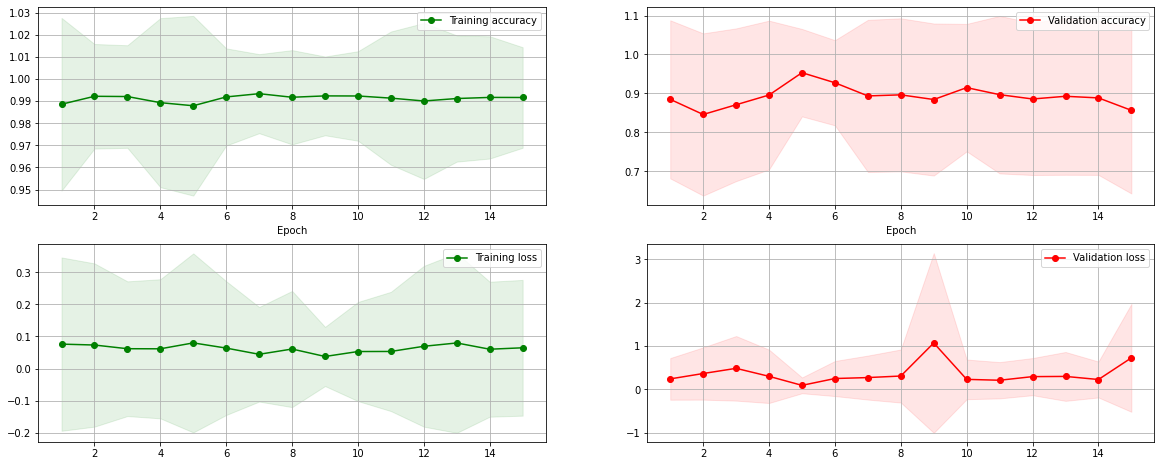

In [48]:
import numpy as np
n_folds = 15

tr_acc_fold_mean = np.mean(train_acc_arr, axis=1)
tr_acc_fold_std = np.std(train_acc_arr, axis=1)

val_acc_fold_mean = np.mean(val_acc_arr, axis=1)
val_acc_fold_std = np.std(val_acc_arr, axis=1)

tr_loss_fold_mean = np.mean(train_loss_arr, axis=1)
tr_loss_fold_std = np.std(train_loss_arr, axis=1)

val_loss_fold_mean = np.mean(val_loss_arr, axis=1)
val_loss_fold_std = np.std(val_loss_arr, axis=1)


_, axes = plt.subplots(2, 2, figsize=(20, 8))

axes[0, 0].grid()
axes[0, 1].grid()

axes[0, 0].fill_between(range(1, n_folds+1), tr_acc_fold_mean - tr_acc_fold_std,
                         tr_acc_fold_mean + tr_acc_fold_std, alpha=0.1,
                         color="g")
axes[0, 1].fill_between(range(1, n_folds+1), val_acc_fold_mean - val_acc_fold_std,
                         val_acc_fold_mean + val_acc_fold_std, alpha=0.1,
                         color="r")
axes[0, 0].plot(range(1, n_folds+1), tr_acc_fold_mean, 'o-', color="g",
                 label="Training accuracy")

axes[0, 1].plot(range(1, n_folds+1), val_acc_fold_mean, 'o-', color="r",
                 label="Validation accuracy")

axes[0, 0].set_xlabel('Epoch')
axes[0, 1].set_xlabel('Epoch')

axes[0, 0].legend(loc="best")
axes[0, 1].legend(loc="best")


axes[1, 0].grid()
axes[1, 1].grid()
axes[1, 0].fill_between(range(1, n_folds+1), tr_loss_fold_mean - tr_loss_fold_std,
                         tr_loss_fold_mean + tr_loss_fold_std, alpha=0.1,
                         color="g")
axes[1, 1].fill_between(range(1, n_folds+1), val_loss_fold_mean - val_loss_fold_std,
                         val_loss_fold_mean + val_loss_fold_std, alpha=0.1,
                         color="r")
axes[1, 0].plot(range(1, n_folds+1), tr_loss_fold_mean, 'o-', color="g",
                 label="Training loss")

axes[1, 1].plot(range(1, n_folds+1), val_loss_fold_mean, 'o-', color="r",
                 label="Validation loss")

axes[1, 0].legend(loc="best")
axes[1, 1].legend(loc="best")


## Tensorboard graph visualization

NOTE: For this to work, you need to have the 6006 port binded from the localhost as shown in the first block

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/model_save_dir_F15 

## Train a model on full dataset

In [5]:
ROOTDIR = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'

csv_path = os.path.join(ROOTDIR, "csv_full")
model_save_path = os.path.join(ROOTDIR, "model_save_dir_full_local")
tfrecords_path = os.path.join(ROOTDIR, 'tfrecords_full')


history = train(
    csv_path,
    model_save_path,
    tfrecords_path,
    volume_shape=(128, 128, 128),
    image_size=(128, 128),
    mode='full'
)

{0: 0.9934934934934935, 1: 1.0065922920892494}
Submodel:  axial
GLOBAL BATCH SIZE:  16
125
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
axial (InputLayer)           [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
activation_6 (Activation)    (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 8)       584       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 8)       32        
__________________________________

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import sys, os
sys.path.append('../defacing')
from models.modelN import CombinedClassifier

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses

## Hard-coded directory paths
ROOTDIR_B = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_B/128'
ROOTDIR_A = '/work/06850/sbansal6/maverick2/mriqc-shared/experiments/experiment_A/128'

csv_path = os.path.join(ROOTDIR, "csv_full")
model_save_path = os.path.join(ROOTDIR_B, "model_save_dir_full")
tfrecords_path = os.path.join(ROOTDIR_B, 'tfrecords_full')
weights_path = os.path.join(model_save_path, 'weights/combined/best-wts.h5')

planes = ['axial', 'coronal', 'sagittal']
for plane in planes:
    model = modelN.Submodel(
        input_shape=image_size,
        dropout=dropout,
        name=plane,
        include_top=True,
         weights=None)
    
    model.load_weights(os.path.join(weights_path, ))
    
    
    
model = CombinedClassifier(
    input_shape=(128, 128), dropout=0.4, wts_root=None, trainable=True
)
model.load_weights(os.path.abspath(weights_path))


dataset_test = get_dataset(
    file_pattern=os.path.join(tfrecords_path, "data-test_*"),
    n_classes=2,
    n_slices = 24,
    batch_size=16,
    volume_shape=(128, 128, 128),
    plane='combined',
    mode='test'
)

METRICS = [
            metrics.BinaryAccuracy(name="accuracy"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.AUC(name="auc"),
        ]

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(learning_rate=1e-3),
    metrics=METRICS,
)

    
results = model.evaluate(dataset_test)
predictions = (model.predict(dataset_test) > 0.5).astype(int)

In [ ]:
print(dataset_test)
import matplotlib.pyplot as plt
corr_pred_map = {}

# for x, y in dataset_test.enumerate():
for x, y in dataset_test.as_numpy_iterator():
    
    batch_predictions = (model.predict(x) > 0.5).astype(int)
    all_imgs = []
    for i in range(len(batch_predictions)):
        if batch_predictions.flatten()[i] != y.flatten()[i].astype(int):
            print("Predicted: ",batch_predictions.flatten()[i], "Actual: ", y.flatten()[i].astype(int))
            
            fig = plt.figure(figsize=(25, 8))
            rows, cols = 3, 16
            use = x['axial']
            for i in range(1, cols*rows + 1):
                if i/cols == 1:
                    use = x['coronal']
                if i/cols == 2:
                    use = x['sagittal']
                    
                fig.add_subplot(rows, cols, i)
                
                plt.imshow(use[(i-1)%cols,:,:, 0])


            plt.show()

## IXI

In [ ]:
import pandas as pd
import glob, os

ixi_root_dir = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/conformed/ixi/face/128'
ixi_deface_root_dir = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/conformed/ixi/deface/128'
cpaths = glob.glob(os.path.join(ixi_root_dir, '*.nii*'))
cpaths_deface = glob.glob(os.path.join(ixi_deface_root_dir, '*.nii*'))

# true_labels = pd.read_csv(os.path.join(test_root_dir, 'test1_images_gt.csv'))
# tl_dict = {}
# for i, row in enumerate(true_labels.values):
    
#     dataset, volume, label = row
#     l = 0 if 'deface' in label else 1
#     tl_dict[str(dataset) + '/' + str(volume)] = l
    
test_df_dict = {}
X, Y = [], []

for path in cpaths:
#     print(path)
    name = '/'.join(path.rsplit('/', 2)[-2:])
    X.append(path)
    Y.append(1)
    
for path in cpaths_deface:
#     print(path)
    name = '/'.join(path.rsplit('/', 2)[-2:])
    X.append(path)
    Y.append(0)


# print(X, Y)
import random

zipped = list(zip(X, Y))
random.shuffle(zipped)
_X, _Y = zip(*zipped)

test_df_dict['X'] = _X
test_df_dict['Y'] = _Y

df_test = pd.DataFrame(data=test_df_dict)
df_test.to_csv(os.path.join("/tf/shank/HDDLinux/Stanford/data/mriqc-shared/test_ixi/csv/testing.csv"), index=False)

## Convert test data to tfrecords

In [ ]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

test_root_dir = "/tf/shank/HDDLinux/Stanford/data/mriqc-shared/test_ixi"
csv_path = os.path.join(test_root_dir, "csv")
tf_records_dir = os.path.join(test_root_dir, "tfrecords")

os.makedirs(tf_records_dir, exist_ok=True)

test_csv_path = os.path.join(csv_path, "testing.csv")
test_paths = pd.read_csv(test_csv_path)["X"].values
test_labels = pd.read_csv(test_csv_path)["Y"].values
test_D = list(zip(test_paths, test_labels))
test_write_path = os.path.join(tf_records_dir, 'data-test_shard-{shard:03d}.tfrec')

nobrainer.tfrecord.write(
    features_labels=test_D,
    filename_template=test_write_path,
    examples_per_shard=3)

In [ ]:
test_root_dir = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/test_ixi'
model_save_path = os.path.join(ROOTDIR_B, "model_save_dir_full")
tfrecords_path = os.path.join(test_root_dir, "tfrecords")
plane = "axial"
dataset_plane = get_dataset(
        file_pattern=os.path.join(tfrecords_path, "data-test_*"),
        n_classes=2,
        batch_size=16,
        volume_shape=(128, 128, 128),
        plane=plane,
        mode='test'
    )

print(dataset_plane)

## Inference

In [ ]:
import sys, os
sys.path.append('../defacing')
from models.modelN import CombinedClassifier
import glob

# Tf packages
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR_B = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_B/128'
ROOTDIR_A = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/experiments/experiment_A/128'
test_root_dir = '/tf/shank/HDDLinux/Stanford/data/mriqc-shared/test_ixi'

model_save_path = os.path.join(ROOTDIR_B, "model_save_dir_full")
tfrecords_path = os.path.join(test_root_dir, "tfrecords")
print("TFRECORDS: ", tfrecords_path)
weights_path = os.path.join(model_save_path, 'weights/combined/best-wts.h5')

planes = ['coronal'] #, 'coronal', 'sagittal']
for plane in planes:
    
    model = modelN.Submodel(
        input_shape=(128, 128),
        dropout=0.2,
        name=plane,
        include_top=True,
        weights=None,
        trainable=False,
    )
    
    print(os.path.join(model_save_path, plane, 'best-wts.h5'))
    
    model.load_weights(os.path.join(model_save_path, 'weights', plane, 'best-wts.h5'))
    
    dataset_plane = get_dataset(
        file_pattern=os.path.join(tfrecords_path, "data-test_*"),
        n_classes=2,
        batch_size=16,
        volume_shape=(128, 128, 128),
        plane=plane,
        mode='test',)
    
    METRICS = [
        metrics.BinaryAccuracy(name="accuracy"),
        metrics.Precision(name="precision"),
        metrics.Recall(name="recall"),
        metrics.AUC(name="auc"),
    ]
    
    model.summary()
    
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=Adam(learning_rate=1e-3),
        metrics=METRICS,
    )
    
#     results = model.evaluate(dataset_plane, batch_size=16)
    predictions = (model.predict(dataset_plane) > 0.5).astype(int)
    
# model = CombinedClassifier(
#     input_shape=(128, 128), dropout=0.4, wts_root=None, trainable=True
# )
# model.load_weights(os.path.abspath(weights_path))

# print(os.path.join(tfrecords_path, "data-test_*"))

# dataset_test = get_dataset(
#     file_pattern=os.path.join(tfrecords_path, "data-test_*"),
#     n_classes=2,
# #     n_slices = 24,
#     batch_size=16,
#     volume_shape=(128, 128, 128),
#     plane='combined',
#     mode='test'
# )

# print(dataset_test)

# METRICS = [
#             metrics.BinaryAccuracy(name="accuracy"),
#             metrics.Precision(name="precision"),
#             metrics.Recall(name="recall"),
#             metrics.AUC(name="auc"),
#         ]

# model.compile(
#     loss=tf.keras.losses.binary_crossentropy,
#     optimizer=Adam(learning_rate=1e-3),
#     metrics=METRICS,
# )

    
# results = model.evaluate(dataset_test, batch_size=16)
# predictions = (model.predict(dataset_test) > 0.5).astype(int)

In [ ]:
print(len(predictions.flatten()))

In [ ]:
import matplotlib.pyplot as plt
corr_pred_map = {}
corr = 0
incorr = 0
for x, y in dataset_plane.as_numpy_iterator():
    
    batch_predictions = (model.predict(x) > 0.5).astype(int)
    all_imgs = []
    for i in range(len(batch_predictions)):
        if batch_predictions.flatten()[i] != y.flatten()[i].astype(int):
            incorr += 1
            print("Predicted: ",batch_predictions.flatten()[i], "Actual: ", y.flatten()[i].astype(int))
        else:
            corr += 1
            
#             fig = plt.figure(figsize=(25, 8))
#             rows, cols = 3, 16
            
#             for i in range(1, cols*rows + 1):
# #                 if i/cols == 1:
# #                     use = x['coronal']
# #                 if i/cols == 2:
# #                     use = x['sagittal']
                    
#                 fig.add_subplot(rows, cols, i)
                
#                 plt.imshow(use[(i-1)%cols,:,:, 0])


#             plt.show()

In [ ]:
print(corr, incorr)